# systematics with the Asimov dataset

To assess the impact of various sources of systematic, we will rely on an Asimov dataset.

In [1]:
## imports and configuration
%cd '/home/naodell/work/wbr/analysis'

from functools import partial
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
from scipy.optimize import minimize
from tqdm import tqdm_notebook

import scripts.plot_tools as pt
import scripts.fit_helpers as fh
from nllfit.nllfitter import ScanParameters

np.set_printoptions(precision=3)
matplotlib.style.use('default')
params = {'legend.fontsize': 20,
          'axes.labelsize': 20,
          'figure.figsize': (8, 8),
          'axes.facecolor': 'white',
          'axes.titlesize':'x-large',
          'xtick.labelsize':18,
          'ytick.labelsize':18,
         }
matplotlib.rcParams.update(params)
%matplotlib inline

/home/naodell/work/wbr/analysis


In [8]:
# configure, get the input data, and do any additional processing that is needed
input_dir  = f'data/templates/bjet_binned/'
selections = ['mumu', 'mutau', 'mu4j', 'emu', 'ee', 'etau', 'e4j']
n_selection = len(selections)
targets    = dict(
                  mumu  = 'lepton2_pt', 
                  ee    = 'lepton2_pt', 
                  emu   = 'lepton2_pt', #'dilepton1_pt_asym', 
                  mutau = 'lepton2_pt', 
                  etau  = 'lepton2_pt', 
                  mu4j  = 'lepton1_pt',
                  e4j   = 'lepton1_pt'
                 )
plot_labels = dict(
                   mumu  = [r'$\sf p_{T, \mu}$', r'$\mu\mu$'],
                   ee    = [r'$\sf p_{T, e}$', r'$ee$'],
                   emu   = [r'$\sf p_{T, \ell}$', r'$e\mu$'],
                   mutau = [r'$\sf p_{T, \tau}$', r'$\mu\tau$'],
                   etau  = [r'$\sf p_{T, \tau}$', r'$e\tau$'],
                   mu4j  = [r'$\sf p_{T, \mu}$', r'$\mu$ + jet'],
                   e4j   = [r'$\sf p_{T, e}$', r'$e$ + jet']
                  )
p_labels = [r'$\beta_{e}$', r'$\beta_{\mu}$', r'$\beta_{\tau}$', r'$\beta_{h}$'
            r'$\sf L_{int}$', 
            r'$\sigma_{t\bar{t}}$',  r'$\sigma_{z}$',  r'$\sigma_{w}$', r'$\sf k_{fakes}$', 
            r'$\sf \epsilon_{e}$', r'$\sf \epsilon_{\mu}$', r'$\sf \epsilon_{\tau}$']

# initial values for W branching fraction (beta_e, beta_mu, beta_tau, beta_h) and tau branching fraction (b_e, b_mu, b_h)
br_tau    = [0.1783, 0.1741, 0.6476]
beta_init = [0.108, 0.108, 0.108, 1 - 3*0.108] 
var_beta  = [0.0009**2, 0.0009**2, 0.0009**2, 0.0031**2]

# initialize fit data
fit_data = fh.FitData(input_dir, selections, targets, bins=[0, 1])

In [3]:
# generate Asimov dataset
toy_data = dict()
for selection in selections:
    toy_data[selection] = dict()
    for b in fit_data._bins:
        # signal component
        templates = fit_data.get_selection_data(selection)
        signal_template = templates['signal'][b]
        signal = fh.signal_mixture_model(beta_init, br_tau, signal_template, sample=False)[0]

        toy_data[selection][b] = signal
        # background component
        for bg in ['zjets', 'wjets', 'fakes']:
            if bg == 'fakes' and selection != 'mu4j':
                continue

            bg_template = templates[bg][b][0]
            toy_data[selection][b] += bg_template

        # mixture

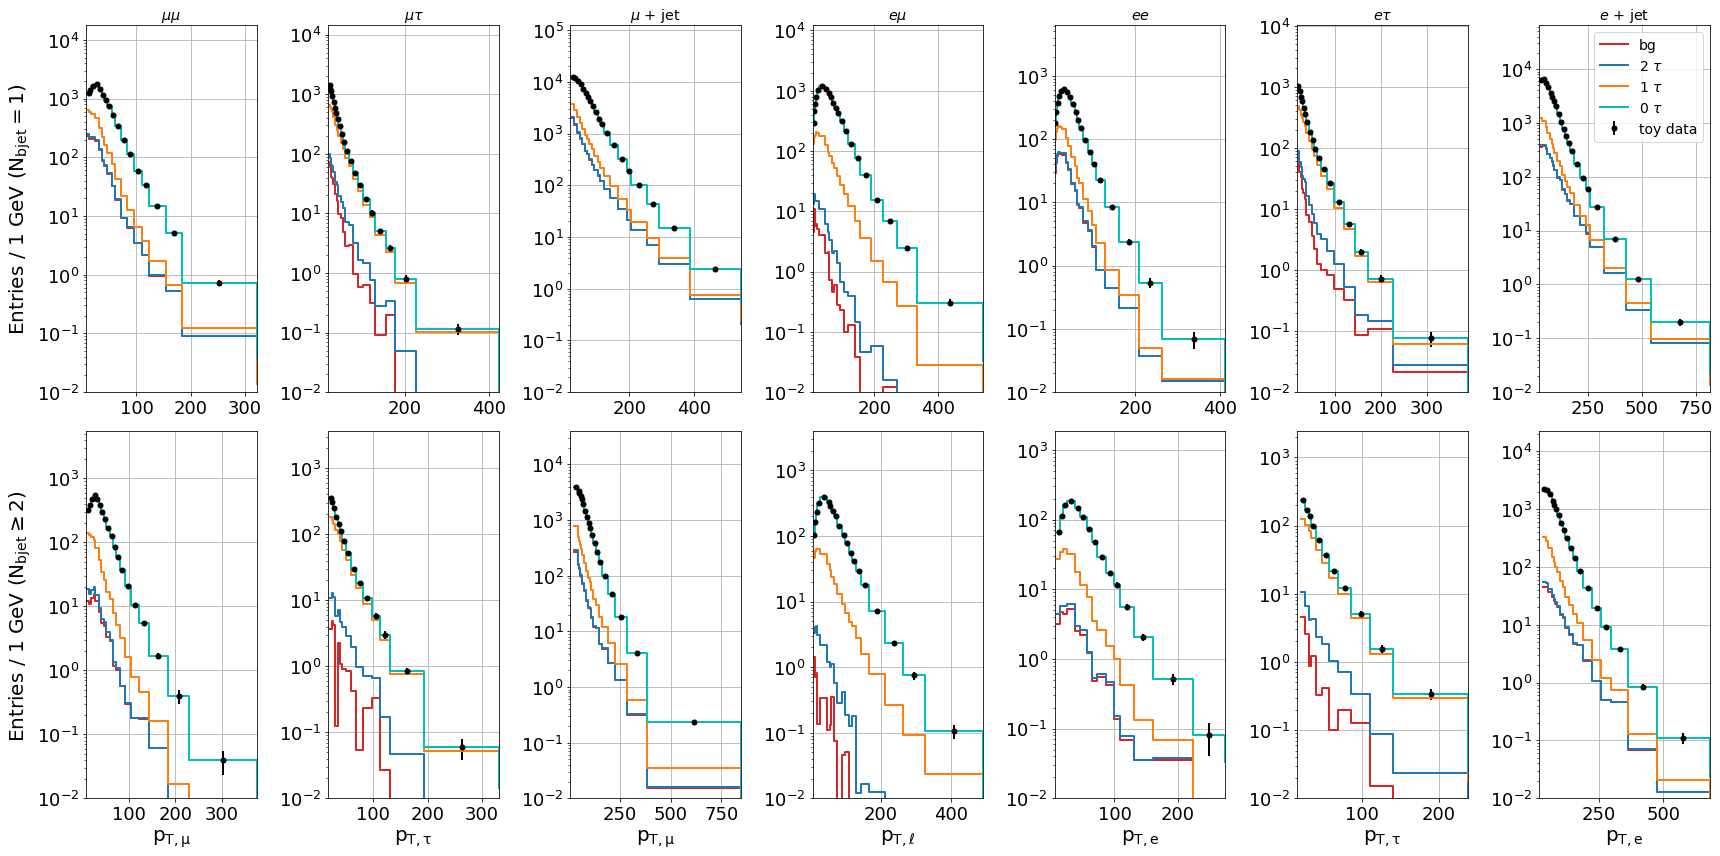

In [4]:
# visualize toy data
fig, axes = plt.subplots(2, 7, figsize=(24, 12), facecolor='white')
for i, selection in enumerate(selections):
    s_data = fit_data.get_selection_data(selection)
#
    for b in fit_data._bins:
        bins = s_data['bins'][b]
        dx = (bins[1:] - bins[:-1])
        dx = np.append(dx, dx[-1]) 
        x = bins + dx/2            

        ax = axes[b][i]
        data = toy_data[selection][b]
        ax.errorbar(x, data/dx, np.sqrt(data)/dx, fmt='ko', linewidth=2., markersize=5)
        
        # validation plot
        br = 0.108
        signal = s_data['signal'][b]
        bg = s_data['wjets'][b][0] + s_data['zjets'][b][0]
        if selection == 'mu4j':
            bg += s_data['fakes'][b][0]
            
        h_notau   = fh.signal_mixture_model([br, br, br, 1. - 3*br], br_tau, signal, mask=fit_data._decay_map['sig_twotau']) + bg
        h_onetau  = fh.signal_mixture_model([br, br, br, 1. - 3*br], br_tau, signal, mask=fit_data._decay_map['sig_onetau']) + h_notau
        h_nominal = fh.signal_mixture_model([br, br, br, 1. - 3*br], br_tau, signal) + bg
        
        ax.plot(bins, bg/dx, drawstyle='steps-post', c='C3', linestyle='-', linewidth=2.)
        ax.plot(bins, h_notau[0]/dx, drawstyle='steps-post', c='C0', linestyle='-', linewidth=2.)
        ax.plot(bins, h_onetau[0]/dx, drawstyle='steps-post', c='C1', linestyle='-', linewidth=2.)
        ax.plot(bins, h_nominal[0]/dx, drawstyle='steps-post', c='c', linestyle='-', linewidth=2.)
        
        xmin, xmax = bins[0]-dx[0], bins[-2]+dx[-2]
        ax.set_xlim(xmin, xmax)
        ax.set_ylim(0.01, 10.*np.max(h_nominal[0]/dx))
        ax.set_yscale('log')
        if b == 0:
            ax.set_title(plot_labels[selection][1])
            if i == 0:
                ax.set_ylabel(r'Entries / 1 GeV ($\sf N_{b jet} = 1$)')
        elif b == 1:
            ax.set_xlabel(plot_labels[selection][0])
            if i == 0:
                ax.set_ylabel(r'Entries / 1 GeV ($\sf N_{b jet} \geq 2$)')
        ax.grid()
    
    axes[0][-1].legend(['bg', r'2 $\tau$', r'1 $\tau$', r'0 $\tau$', 'toy data'], fontsize=14)
    
plt.tight_layout()
plt.savefig('plots/toy_mc_example.pdf')
plt.show()

In [9]:
# Carry out the fits
p_init = list(fit_data.get_params_init()) + 8*[1., ] # niceify this: there is an additional paramter initialized to 1. for each nuisance parameter
bnds   = 3*[(0.09, 0.13), ] + [(0.6, 0.7)] + 8*[(0.5, 1.5), ]
cost_type = 'poisson'
result = minimize(fit_data.objective, p_init,
                  method      = 'TNC',
                  bounds      = bnds,
                  args        = (toy_data, cost_type)
                 ) 

fobj = partial(fit_data.objective, data=toy_data, cost_type=cost_type)
cov = fh.calculate_covariance(fobj, result.x)
print(result.x)
#print(cov[0])
print(100*cov[0]/result.x)
df_cov = pd.DataFrame(cov[1], columns=p_labels, index=p_labels)
pd.set_option('precision', 3)
df_cov

[0.108 0.108 0.108 0.676 1.    1.    1.    1.    1.    1.    1.    1.   ]
[0.767 0.655 1.61  0.279 0.378 0.53  3.549 3.358 3.868 0.739 0.679 1.033]


ValueError: Shape of passed values is (12, 12), indices imply (11, 12)

NameError: name 'nuisance_params' is not defined

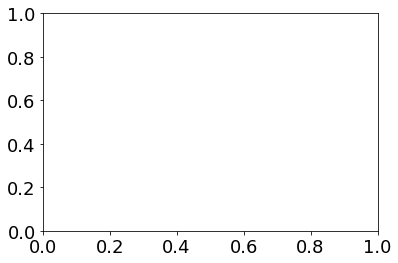

In [6]:
# plot the pulls
ax = plt.subplot()

mean, stderr = nuisance_params.mean(axis=1), nuisance_params.std(axis=1)
iy = np.arange(nuisance_params.shape[0])
ax.errorbar(mean, iy+1, xerr = stderr, 
            fmt = 'ko',
            ecolor = 'k',
            capsize = 0.,
            elinewidth = 2.,
            alpha = 0.9
           )

err0 = np.array([0.025, 0.05, 0.05, 0.05, 0.5])#, 0.01, 0.01, 0.05]) 
ax.errorbar(np.zeros(mean.size), iy+1, xerr = err0, 
            fmt = 'none',
            ecolor = 'b',
            capsize = 0.,
            elinewidth = 25.,
            alpha = 0.25
           )

ax.set_yticks(iy+1)
ax.set_yticklabels(p_labels)

ax.set_xlim(-0.1, 0.1)
ax.set_ylim(0., iy[-1]+2)
ax.set_xlabel(r'$\sf \frac{p_{0} - \tilde{p}}{p_{0}}$')
ax.set_title('nuisance parameters')
ax.legend(['postfit', 'prefit'])

plt.plot([0, 0], [0, iy[-1]+2], c='C3', linestyle='--')
plt.tight_layout()
plt.grid(linestyle='--')
plt.savefig(f'plots/systematics/nuisance_parameters_bias_{n_samples}.pdf')
plt.show()